In [1]:
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas  as pd
import cv2 
import numpy as np
import os
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [2]:
train_image_root_dir="C:\\Users\\rudra\\Downloads\\Object_Detection_other_method\\train\\image"
train_label_root_dir="C:\\Users\\rudra\\Downloads\\Object_Detection_other_method\\train\\label"
data=[]
for image in os.listdir(train_image_root_dir):
    file_path=os.path.join(train_image_root_dir,image)
    img=cv2.imread(file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    json_file_path=os.path.join(train_label_root_dir,image.split('.')[0]+".json")
    with open(json_file_path,'r') as f:
        obj=json.load(f)
        shape=obj["shapes"][0]
        box=shape["points"]
        box=sum(box,[])
    for i in range(len(box)):
        box[i]=int(box[i])
    data.append((file_path,json_file_path,img,box))

df_train=pd.DataFrame(data,columns=["file_path","json_file_path","img","box"])
df_train

,file_path,json_file_path,img,box
0,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[61, 58, 53, 49, 47, 48, 50, 52, 49, 52, 55, ...","[227, 17, 381, 210]"
1,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[6, 6, 6, 7, 7, 7, 7, 7, 5, 6, 8, 8, 7, 7, 9,...","[34, 10, 125, 111]"
2,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[250, 250, 250, 250, 250, 250, 250, 250, 251,...","[167, 15, 417, 262]"
3,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[223, 223, 224, 224, 225, 226, 227, 227, 229,...","[52, 57, 177, 172]"
4,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[44, 44, 277, 341]"
...,...,...,...,...
1200,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[180, 180, 180, 179, 179, 178, 178, 178, 176,...","[293, 129, 395, 238]"
1201,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[196, 196, 196, 196, 196, 196, 196, 196, 199,...","[219, 59, 406, 320]"
1202,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[193, 193, 193, 193, 193, 193, 193, 193, 192,...","[196, 127, 449, 378]"
1203,C:\Users\rudra\Downloads\Object_Detection_othe...,C:\Users\rudra\Downloads\Object_Detection_othe...,"[[163, 162, 161, 160, 158, 153, 147, 142, 139,...","[412, 228, 469, 290]"


In [3]:
def process_images(paths):
    batch_images = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0  
        batch_images.append(img)
    return np.array(batch_images)

batch_size = 60

num_images = len(df_train["file_path"])
processed_images = []

for i in range(0, num_images, batch_size):
    batch_paths = df_train["file_path"][i:i+batch_size].tolist()
    batch_processed = process_images(batch_paths)
    processed_images.append(batch_processed)

# Concatenate processed batches into a single numpy array
X= np.concatenate(processed_images, axis=0)
X.shape

(1205, 128, 128, 3)

In [4]:
def format_image(img, box):
    height, width= img.shape 
    max_size = max(height, width)
    r = max_size / 128
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
    new_image = np.zeros((128, 128), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

In [9]:
new_image,new_box=format_image(df_train["img"][0],df_train['box'][0])
new_box,new_image

([4672, -7509, 48768, 17920],
 array([[52, 51, 56, ..., 12, 47, 37],
        [52, 53, 61, ..., 28, 31, 36],
        [51, 52, 52, ..., 56, 11,  7],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8))

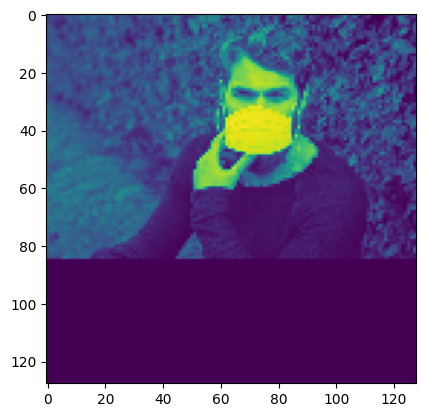

In [14]:
image=cv2.rectangle(new_image,(new_box[0],new_box[1]),((new_box[0]+new_box[2]),(new_box[1]+new_box[3])),color=(0,0,255),thickness=2)
plt.imshow(image)